# Trabajo Practico 1 - Analisis de Series Temporales

## Importacion de Librerias

In [1]:
import pandas as pd

import numpy as np

import math

import seaborn as sns

import scipy.stats
from scipy import stats

import pylab

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error
from arch.unitroot import PhillipsPerron

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
tema_azul = ['#0000CC','#3366FF','#99CCFF']
tema_rojo = ['#CC0000','#FF3333','#FF9999']
tema_verde = ['#009900','#33AA33','#55BB55']
tema_negro = ['#000000','#333333','#555555']

## Definicion de Funciones

### Trabajo de Datos

In [4]:
def filtrar_serie(serie, start_date, end_date):
    serie = serie[(serie.index >= start_date) & (serie.index <= end_date)]
    return serie

### Graficas

In [5]:
def autocov_autocorr(s1,s2, numlag= 20, color = ['#000000','#333333','#555555']):
  p1, axes = plt.subplots(3,2,figsize=(14,9), sharex=True, sharey=False )

  axes[2,0].set_xlabel('Lags', fontsize=8)
  axes[2,1].set_xlabel('Lags', fontsize=8)
  
  axes[0,0].set_ylabel('FAC', fontsize=8)
  axes[1,0].set_ylabel('FACP', fontsize=8)
  axes[2,0].set_ylabel('FAS', fontsize=8)

  #grafico correlacion
  plot_acf(s1, lags=numlag, ax= axes[0,0], color=color[0], label="ACF", vlines_kwargs={"colors":color[0]})
  axes[0,0].set_title(label = s1.name, fontsize=9)
  axes[0,0].tick_params(axis='both', labelsize=7)
  for item in axes[0,0].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')

  plot_acf(s2, lags=numlag, ax= axes[0,1], color=color[0], label="ACF", vlines_kwargs={"colors":color[0]}, title=s2.name)
  axes[0,1].set_title(label = s2.name, fontsize=9)
  axes[0,1].tick_params(axis='both', labelsize=7)
  for item in axes[0,1].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')
  
  #grafico correlacion parcial
  plot_pacf(s1, lags=numlag, ax= axes[1,0], color=color[1], label="PACF", vlines_kwargs={"colors":color[1]}, title='', method='ywm')
  axes[1,0].tick_params(axis='both', labelsize=7)
  for item in axes[1,0].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')

  plot_pacf(s2, lags=numlag, ax= axes[1,1], color=color[1], label="PACF", vlines_kwargs={"colors":color[2]}, title='', method='ywm')
  axes[1,1].tick_params(axis='both', labelsize=7)
  for item in axes[1,1].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')


  #grafico covarianza
  axes[2,0].plot(tsa.acovf(s1,fft=False, nlag=numlag), color=color[2], label='AutoCov')
  axes[2,0].tick_params(axis='both', labelsize=7)
  axes[2,1].plot(tsa.acovf(s2,fft=False, nlag=numlag), color=color[2], label='AutoCov')
  axes[2,1].tick_params(axis='both', labelsize=7)

  #p1.legend()
  plt.show()
#autocov_autocorr(df.ventas_ajustado, df.diff1, 20, tema_rojo)

In [6]:
def prueba_residuos(resid, color = ['#000000','#333333','#555555']):
    p1, axes = plt.subplots(3,2,figsize=(15,10))
    #p1, axes = plt.subplot_mosaic('AB;CD;EF;GG')

    plot_acf(resid, ax= axes[0,0], color=color[0], vlines_kwargs={"colors":color[0]})
    axes[0,0].set_title(label = 'Autocorrelacion', fontsize=10)
    axes[0,0].tick_params(axis='both', labelsize=7)
    axes[0,0].get_lines()[1].set(markersize = 5.0, markerfacecolor = color[1], markeredgecolor = color[2])
    for item in axes[0,0].collections:
        #change the color of the CI 
        if type(item)==PolyCollection:
            item.set_facecolor('#AAAAAA')

    #plot_pacf(resid, ax= axes[0,1]);
    plot_pacf(resid, ax= axes[0,1], color=color[0], vlines_kwargs={"colors":color[0]})
    axes[0,1].set_title(label = 'Autocorrelacion Parcial', fontsize=10)
    axes[0,1].tick_params(axis='both', labelsize=7)
    axes[0,1].get_lines()[1].set(markersize = 5.0, markerfacecolor = color[1], markeredgecolor = color[2])
    for item in axes[0,1].collections:
        #change the color of the CI 
        if type(item)==PolyCollection:
            item.set_facecolor('#AAAAAA')

    axes[1,0].plot(resid, color = color[1])
    axes[1,0].set_title("Residuos del modelo",size=10)
    axes[1,0].tick_params(axis='both', labelsize=7)

    sns.distplot(resid,bins=12,color=color[1], ax=axes[1,1])
    axes[1,1].set_title(f'Histograma de residuos - Shapiro p-value = {stats.shapiro(resid).pvalue:.4f}',size=10)

    scipy.stats.probplot(resid, plot = axes[2,0])
    axes[2,0].set_title("QQ Plot", size = 10)
    axes[2,0].get_lines()[0].set(markersize = 3.0, markerfacecolor = color[1], markeredgecolor = color[2], color = color[1])
    axes[2,0].get_lines()[1].set(color = color[1])
    axes[2,0].tick_params(axis='both', labelsize=7)

    Incorr_residuos_modelo=sm.stats.acorr_ljungbox(resid, lags=10)
    axes[2,1].plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
    axes[2,1].set_title("Grafico de incorrelacion de los residuos del modelo", size = 10)
    axes[2,1].set_ylabel("P-valores ")
    axes[2,1].get_lines()[0].set(markersize = 10.0, markerfacecolor = color[1], markeredgecolor = color[2], color = color[1])
    axes[2,1].tick_params(axis='both', labelsize=7)

#prueba_residuos(modelo_sarima.resid, tema_verde)

In [7]:
def graficar_pred(train, test, pred, confint, xlabel="Fecha", ylabel="ARS$", color = ['#000000','#333333','#555555']):
    p1, axes = plt.subplot_mosaic('AB;CC',figsize=(15,10))

    axes['A'].plot(train, color = color[0])
    axes['A'].set_xlabel(xlabel)
    axes['A'].set_ylabel(ylabel)
    axes['A'].set_title('Serie Original')
    axes['A'].grid(True, color='0.6', dashes=(5,2,1,2))

    axes['B'].plot(confint.iloc[:,1],label="", color='#222222')
    axes['B'].plot(confint.iloc[:,0],label="", color='#222222')
    axes['B'].plot(test, label="Valores Observados", color = color[0])
    axes['B'].plot(pred, label="Predicciones", color = color[2])
    axes['B'].fill_between(pred.index, confint.iloc[:,1], confint.iloc[:,0], facecolor=color[2], alpha=0.3)
    axes['B'].fill_between(pred.index, pred, test, facecolor=color[1], alpha=0.6)
    axes['B'].set_xlabel(xlabel)
    axes['B'].set_ylabel(ylabel)
    axes['B'].set_title('Predicciones - Intervalo de Confianza')
    axes['B'].legend(loc=0)
    axes['B'].grid(True, color='0.6', dashes=(5,2,1,2))

    axes['C'].plot(train, color = color[0])
    axes['C'].plot(test, color = color[1])
    axes['C'].plot(pred, color = color[2])
    axes['C'].set_xlabel(xlabel)
    axes['C'].set_ylabel(ylabel)
    axes['C'].set_title('Valores Reales vs Observados')
    axes['C'].fill_between(pred.index, pred, test, facecolor=color[1], alpha=0.8)
    axes['C'].fill_between(pred.index, confint.iloc[:,1], confint.iloc[:,0], facecolor=color[2], alpha=0.3)
    axes['C'].grid(True, color='0.6', dashes=(5,2,1,2))

#graficar_pred(train, test[:16], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int(), color = tema_azul)

### Tests Estadisticos

In [8]:
def print_test_adf(y):
  print("_".center(120, '_'))
  print(f'Augmented Dickey-Fuller')
  print(f'Estadistico ADF\t\tp-Valor\tEstacionaridad\tModo')
  resultado = adfuller(y, regression='c')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tConstante sola')

  resultado = adfuller(y, regression='ct')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tConstante y Tendencia Lineal')

  resultado = adfuller(y, regression='ctt')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tConstante y Tendencia Lineal y Cuadratica')

  resultado = adfuller(y, regression='n')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tSin Contante ni Tendencia')
  print("_".center(120, '_'))
#print_test_adf(df.ventas_ajustado)
#print_test_adf(df.diff1)

In [9]:
def Phillips_Perron(series, **k):

    params = {'n':'No incluye término independiente ni lineal',
              'c':'Con término independiente, Sin término lineal',
              'ct':'Incluye ambos términos'
              }
    print("_".center(120, '_'))
    print(f'Phillips-Perron')
    print(f'Estadistico PP\tp-Valor\t\tNumLags\t\tEstacionaridad\tnDiffs\tTipo_Regresion')
    for param in params:
        pp = PhillipsPerron(series,trend=param, **k)
        print(f"{pp.stat:.2f}\t\t{pp.pvalue:.4f}\t\t{pp.lags}\t\t{'No' if pp.pvalue > 0.05 else 'Si'}\t\t{ndiffs(series, test='pp')}\t{param}-{params.get(param)}")
    print("_".center(120, '_'))

#Phillips_Perron(df.ventas_ajustado)
#Phillips_Perron(df.diff1)

In [10]:
def kpss_test(series, **kw):

    params = {'c':'estacionarios alrededor de una constante.',
              'ct': 'estacionarios alrededor de una tendencia.'
             }
    print("_".center(120, '_'))
    print(f'KPSS')
    print(f'Estad. KPSS\tp-Valor\t\tNumLags\t\tEstacionaridad\tnDiffs\tTipo_Regresion')
    
    for param in params:
        statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)
        print(f"{statistic:.4f}\t\t{p_value:.4f}\t\t{n_lags}\t\t{'No' if p_value < 0.05 else 'Si'}\t\t{ndiffs(series, test='kpss')}\t{param} - {params.get(param)}")
    print("_".center(120, '_'))
#kpss_test(df.ventas_ajustado)

In [11]:
def medidas_error(serie_test, serie_pred):
    MSE = mean_squared_error(serie_test, serie_pred)
    MAE = mean_absolute_error(serie_test, serie_pred)
    RMSE = np.sqrt(mean_squared_error(serie_test, serie_pred))
    MAPE = np.mean(abs((serie_test-serie_pred)/serie_test))

    return MSE, MAE, RMSE, MAPE
#evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

In [12]:
def evaluar_metricas(serie_test, serie_pred):
    serie_test.reset_index()
    serie_pred.reset_index()
    print(f'MSE:\t{mean_squared_error(serie_test, serie_pred):.0f}')
    print(f'MAE:\t{mean_absolute_error(serie_test, serie_pred):.0f}')
    print(f'RMSE:\t{np.sqrt(mean_squared_error(serie_test, serie_pred)):.0f}')
    print(f'MAPE:\t{round(np.mean(abs((serie_test-serie_pred)/serie_test)),4):.3f}')

#evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

In [13]:
def grangers_causation_matrix(data, variables, maxlag, testgr='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [(test_result[i+1][0][testgr][1],i+1) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#grangers_causation_matrix(train2, variables = train2.columns, maxlag=5, verbose=False)

In [14]:
def highlight_min(s):
    is_min = s == s.min()
    return [f'background-color: green' if v else '' for v in is_min]

In [15]:
def calcular_errores(test_serie, modelos_alt_nombres, modelos_alt, per = 16):
    df_errores = pd.DataFrame()
    df_errores['Modelo'] = modelos_alt_nombres
    df_errores['Akaike'] = [m.aic for m in modelos_alt]

    i, MSE, MAE, RMSE, MAPE = 0, [], [], [], []
    for m in modelos_alt:
        pred_m = m.get_forecast(per)
        m_MSE, m_MAE, m_RMSE, m_MAPE = medidas_error(test_serie[:per], pred_m.predicted_mean )
        MSE = np.append(MSE, m_MSE)
        MAE = np.append(MAE, m_MAE)
        RMSE = np.append(RMSE, m_RMSE)
        MAPE = np.append(MAPE, m_MAPE)

    df_errores['MSE'] = MSE
    df_errores['MAE'] = MAE
    df_errores['RMSE'] = RMSE
    df_errores['MAPE'] = MAPE
    
    df_errores.style.apply(highlight_min, subset=['Akaike', 'MSE', 'MAE','RMSE','MAPE'])\
        .format({'Akaike': "{:.0f}",'MSE': "{:.2E}",'MAE': "{:.2E}",'RMSE': "{:.2E}",'MAPE': "{:.0%}"})
    
    return df_errores

#df_err = calcular_errores(test, modelos_alt_nombres, modelos_alt, 10)


## Importacion y Trabajo de Datos

In [16]:
vent_full = pd.read_excel('.\Data\Descarga_VENTAS_POR_LOCALES_NB_050923.xlsx',skiprows=1)
# df_vent = vent_full.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
# df_vent.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
# df_vent.mes = pd.to_datetime(df_vent.mes, dayfirst = True, format = '%m/%Y')
# df_vent = df_vent.sort_values(by = 'mes')
# df_vent.set_index('mes', inplace = True)
# Drop column: 'Valores'
vent_full = vent_full.drop(columns=['Valores'])
# Drop column: 'Centro Comercial'
vent_full = vent_full.drop(columns=['Centro Comercial'])
# Drop column: 'Razón Social'
#vent_full = vent_full.drop(columns=['Razón Social'])
# Drop column: 'Identificacion'
vent_full = vent_full.drop(columns=['Identificacion'])
# Drop column: 'Contrato'
vent_full = vent_full.drop(columns=['Contrato'])
# Drop column: 'Estado'
vent_full = vent_full.drop(columns=['Estado'])
# Drop column: 'Faltan'
vent_full = vent_full.drop(columns=['Faltan'])
# Drop column: 'Cero'
vent_full = vent_full.drop(columns=['Cero'])
# Drop column: 'Calculo'
vent_full = vent_full.drop(columns=['Calculo'])
# Change column type to category for column: 'Nombre Comercial'
vent_full = vent_full.astype({'Nombre Comercial': 'category'})
# Change column type to category for column: 'Local'
vent_full = vent_full.astype({'Local': 'category'})
# Change column type to category for column: 'Rubro'
vent_full = vent_full.astype({'Rubro': 'category'})
# Change column type to datetime64[ns] for column: 'Periodo'
vent_full = vent_full.astype({'Periodo': 'datetime64[ns]'})
# Change column type to category for column: 'Rubros'
vent_full = vent_full.astype({'Rubros': 'category'})

In [17]:
df_ipc = pd.read_excel('.\Data\Tabla_IPC.xlsx',skiprows=1)
df_ipc.rename(columns={'Fecha': 'fecha', 'Indice': 'ipc'}, inplace = True)
df_ipc.set_index('fecha', inplace=True)
df_ipc['ipc_previo'] = df_ipc['ipc'].shift(1)
df_ipc['ipc_intermensual'] = (df_ipc['ipc'] - df_ipc['ipc_previo']) / df_ipc['ipc']
df_ipc.reset_index(inplace=True)
df_ipc.head()

,fecha,ipc,ipc_previo,ipc_intermensual
0,2016-12-01,100.0000,NaN,NaN
1,2017-01-01,101.5859,100.0000,0.015611
2,2017-02-01,103.6859,101.5859,0.020253
3,2017-03-01,106.1476,103.6859,0.023191
4,2017-04-01,108.9667,106.1476,0.025871


In [18]:
df_usd = pd.read_excel('.\Data\Dolar_Evolución.xlsx',skiprows=0)
df_usd = df_usd.iloc[:, 1:]
df_usd.columns = ['fecha', 'ofi', 'blue']
df_usd.set_index('fecha', inplace=True)
df_usd.head()

,ofi,blue
fecha,,
2015-01-01,8.55,13.50
2015-02-01,8.63,12.93
2015-03-01,8.72,12.52
2015-04-01,8.81,12.60
2015-05-01,8.90,12.55


In [19]:
df_clima = pd.read_excel('.\Data\Clima.xlsx',skiprows=0)

Proceso de datos

In [20]:
df_vent_full = vent_full
df_vent_full = pd.merge(df_vent_full, df_ipc, left_on = 'Periodo', right_on= 'fecha' , how='outer')
df_vent_full = pd.merge(df_vent_full, df_usd, left_on = 'Periodo', right_on= 'fecha' , how='left')
df_vent_full.dropna(subset=['ipc'], inplace=True)
df_vent_full.dropna(subset=['blue'], inplace=True)
df_vent_full['ventas_ajustado'] = df_vent_full['Importe'] / (1 + df_vent_full['ipc_intermensual']) / df_vent_full['blue']

In [21]:
df_vent_full = df_vent_full.sort_values(by = ['Nombre Comercial', 'Periodo'])

for i in range(12):
    df_vent_full[f'lag{i+1}'] = df_vent_full.groupby(['Nombre Comercial'])['ventas_ajustado'].shift(periods=i+1)

df_vent_full['diff1'] = df_vent_full.groupby(['Nombre Comercial'])['ventas_ajustado'].diff()

In [22]:
df_vent_full['quarter'] = df_vent_full['Periodo'].dt.quarter
df_vent_full['month'] = df_vent_full['Periodo'].dt.month
df_vent_full['year'] = df_vent_full['Periodo'].dt.year

In [23]:
df_vent_full = pd.merge(df_vent_full, df_clima, left_on='Periodo', right_on='fecha', how='left')

In [24]:
df_retail = vent_full[(vent_full['Razón Social'] != 'GD WORK SA') & (vent_full['Rubro'] != 'SUPERMERCADO')]
df_retail = df_retail.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_retail.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_retail.mes = pd.to_datetime(df_retail.mes, dayfirst = True, format = '%m/%Y')
df_retail = df_retail.sort_values(by = 'mes')
#df_retail.set_index('mes', inplace = True)
df_retail.head()

,mes,ventas
0,2015-01-01,35881254.22
1,2015-02-01,35994300.23
2,2015-03-01,41635908.20
3,2015-04-01,41074614.00
4,2015-05-01,43747283.60


In [25]:
df_super = vent_full[vent_full['Rubro'] == 'SUPERMERCADO']
df_super = df_super.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_super.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_super.mes = pd.to_datetime(df_super.mes, dayfirst = True, format = '%m/%Y')
df_super = df_super.sort_values(by = 'mes')
#df_super.set_index('mes', inplace = True)
df_super.head()

,mes,ventas
0,2015-01-01,26752338.67
1,2015-02-01,26568913.12
2,2015-03-01,28851468.57
3,2015-04-01,27569572.80
4,2015-05-01,27087848.86


In [26]:
df_cowork = vent_full[vent_full['Razón Social'] == 'GD WORK SA']
df_cowork = df_cowork.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_cowork.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_cowork.mes = pd.to_datetime(df_cowork.mes, dayfirst = True, format = '%m/%Y')
df_cowork = df_cowork.sort_values(by = 'mes')
#df_cowork.set_index('mes', inplace = True)
df_cowork.head()

,mes,ventas
0,2019-01-01,824754.21
1,2019-02-01,983820.43
2,2019-03-01,1281202.80
3,2019-04-01,2000058.99
4,2019-05-01,1787994.13


In [27]:
df_retail = pd.merge(df_retail, df_ipc, left_on = 'mes', right_on= 'fecha' , how='outer')
df_retail = pd.merge(df_retail, df_usd, left_on = 'mes', right_on= 'fecha' , how='left')
df_retail.dropna(subset=['ipc'], inplace=True)
df_retail.dropna(subset=['blue'], inplace=True)
df_retail['ventas_ajustado'] = df_retail['ventas'] / (1 + df_retail['ipc_intermensual']) / df_retail['blue']

In [28]:
df_retail = df_retail.sort_values(by = ['mes'])

for i in range(12):
    df_retail[f'lag{i+1}'] = df_retail['ventas_ajustado'].shift(periods=i+1)

df_retail['diff1'] = df_retail['ventas_ajustado'].diff()

In [29]:
df_retail['quarter'] = df_retail['mes'].dt.quarter
df_retail['month'] = df_retail['mes'].dt.month
df_retail['year'] = df_retail['mes'].dt.year

In [30]:
df_retail = pd.merge(df_retail, df_clima, left_on='mes', right_on='fecha', how='left')

In [31]:
df_retail

,mes,ventas,fecha_x,ipc,ipc_previo,ipc_intermensual,ofi,blue,ventas_ajustado,lag1,...,LluviaFuerte,DiasNublados,DiasNubladosLeve,DiasNubladosFuerte,TempMinAvg,TempAvg,TempMinAvg.1,DiasCalurosos,DiasFrios,DiasTemplados
0,2016-12-01,1.147989e+08,2016-12-01,100.0000,NaN,NaN,15.70,16.47,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,7.163752e+07,2017-01-01,101.5859,100.0000,0.015611,15.70,16.24,4.343371e+06,NaN,...,0.0,9.0,7.0,3.0,22.0,26.0,30.0,11.0,0.0,12.0
2,2017-02-01,6.910457e+07,2017-02-01,103.6859,101.5859,0.020253,15.30,15.88,4.265286e+06,4.343371e+06,...,2.0,23.0,22.0,9.0,21.0,25.0,29.0,19.0,0.0,23.0
3,2017-03-01,8.108201e+07,2017-03-01,106.1476,103.6859,0.023191,15.20,15.58,5.086280e+06,4.265286e+06,...,2.0,24.0,18.0,7.0,19.0,23.0,27.0,6.0,0.0,29.0
4,2017-04-01,8.356406e+07,2017-04-01,108.9667,106.1476,0.025871,15.20,15.59,5.224931e+06,5.086280e+06,...,2.0,26.0,25.0,7.0,16.0,18.0,22.0,0.0,0.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2023-04-01,1.625815e+09,2023-04-01,1497.2147,1381.1601,0.077514,217.44,395.00,3.819893e+06,3.468172e+06,...,1.0,30.0,26.0,15.0,14.0,18.0,23.0,4.0,0.0,30.0
77,2023-05-01,1.721765e+09,2023-05-01,1613.5895,1497.2147,0.072122,232.09,469.00,3.424183e+06,3.819893e+06,...,1.0,29.0,27.0,18.0,13.0,16.0,20.0,0.0,1.0,29.0
78,2023-06-01,1.964129e+09,2023-06-01,1709.6115,1613.5895,0.056166,251.43,490.00,3.795262e+06,3.424183e+06,...,0.0,29.0,24.0,16.0,10.0,13.0,16.0,0.0,8.0,22.0
79,2023-07-01,1.932999e+09,2023-07-01,1818.0838,1709.6115,0.059663,271.55,495.00,3.685180e+06,3.795262e+06,...,1.0,29.0,29.0,19.0,10.0,12.0,15.0,0.0,10.0,19.0


Separacion Train-Test

testing = julio 2022 y en adelante

In [32]:
#train = df_vent[df_vent['Periodo'] < '2022-06-30']
#test = df_vent[df_vent['Periodo'] > '2022-06-30']

In [33]:
def sumarizar_ventas(df):
    res = pd.DataFrame(df.groupby(by='Periodo').ventas_ajustado.sum())
    return res

In [34]:
# tema = tema_rojo
# sum_train = sumarizar_ventas(train)
# sum_train.ventas_ajustado.plot(figsize=(20,5), title = 'Ventas', color = tema[0])

In [35]:
df = df_retail

In [36]:
# Se cargan las librerías
from pandas import DataFrame
from pandas import concat
import random
from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from pandas import DataFrame
from pandas import concat
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from IPython.display import YouTubeVideo
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from darts import TimeSeries
import pmdarima as pm
#from darts.models import (NaiveSeasonal,NaiveDrift,RNNModel,Prophet,ExponentialSmoothing,ARIMA,AutoARIMA,TCNModel,TransformerModel,Theta,FFT)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [37]:
# Se redefinen las variables para poder aplicar la librería Prophet
df = df.rename({'mes':'ds','ventas_ajustado':'y'}, axis='columns')
#df_retail.head()

In [38]:
# Se define la base de entrenamiento (90%) y testeo (10%)
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]
#test.info()

In [39]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [40]:
m = Prophet(interval_width=0.95)
m.fit(train)

17:37:13 - cmdstanpy - INFO - Chain [1] start processing


17:37:13 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# Se define la cantidad de períodos a predecir. 44 equivale a la base de testeo
future = m.make_future_dataframe(periods=13, freq='MS')

In [42]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
75,2023-04-01,3.577597e+06,2.556134e+06,4.497884e+06
76,2023-05-01,3.432005e+06,2.514174e+06,4.360551e+06
77,2023-06-01,3.963287e+06,2.924031e+06,4.857135e+06
78,2023-07-01,3.865001e+06,2.890268e+06,4.845667e+06
79,2023-08-01,3.297988e+06,2.355784e+06,4.283683e+06


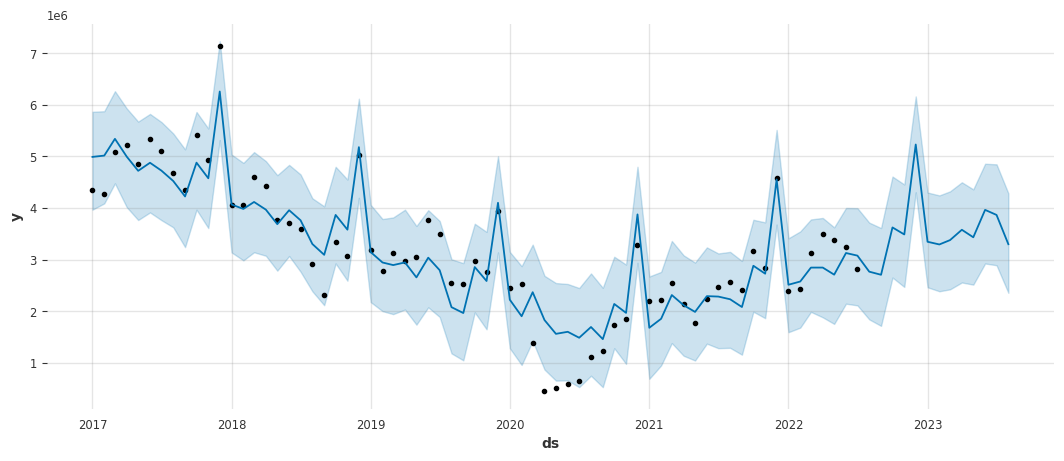

In [43]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

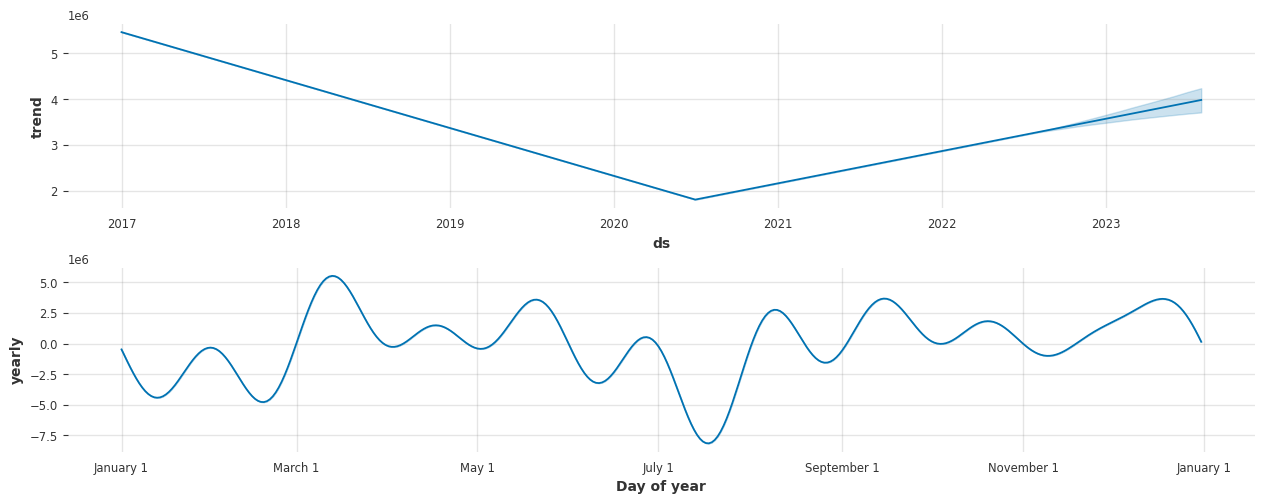

In [44]:
fig2 = m.plot_components(forecast)
fig2.set_figheight(5)
fig2.set_figwidth(13)

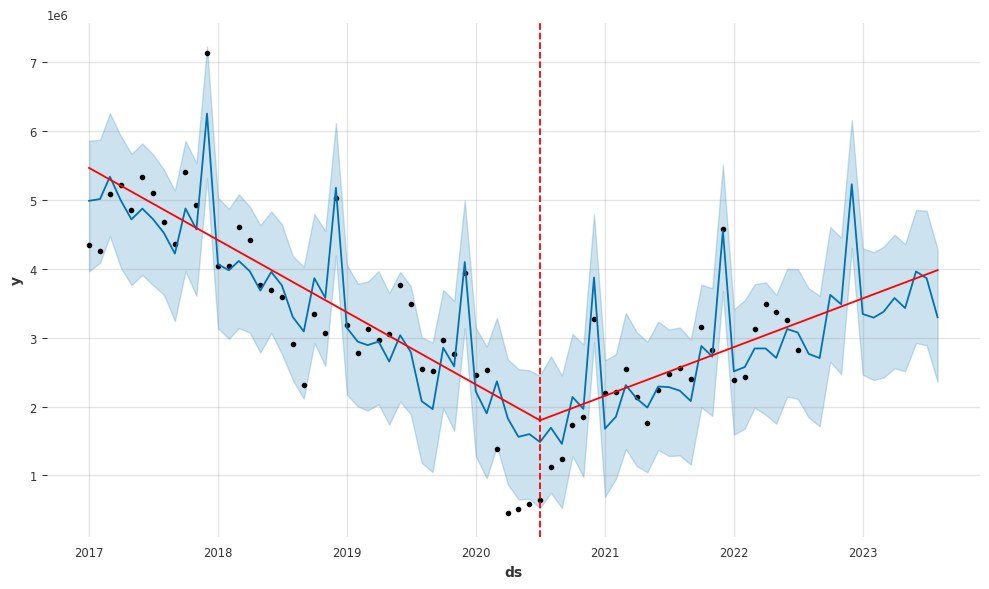

In [45]:
# Se grafican los puntos de cambio
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [46]:
X_tst_forecast = m.predict(test)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8,2023-04-01,3.577597e+06,2.588104e+06,4.539940e+06
9,2023-05-01,3.432005e+06,2.492527e+06,4.369062e+06
10,2023-06-01,3.963287e+06,2.942706e+06,4.995598e+06
11,2023-07-01,3.865001e+06,2.859314e+06,4.855932e+06
12,2023-08-01,3.297988e+06,2.314027e+06,4.233347e+06


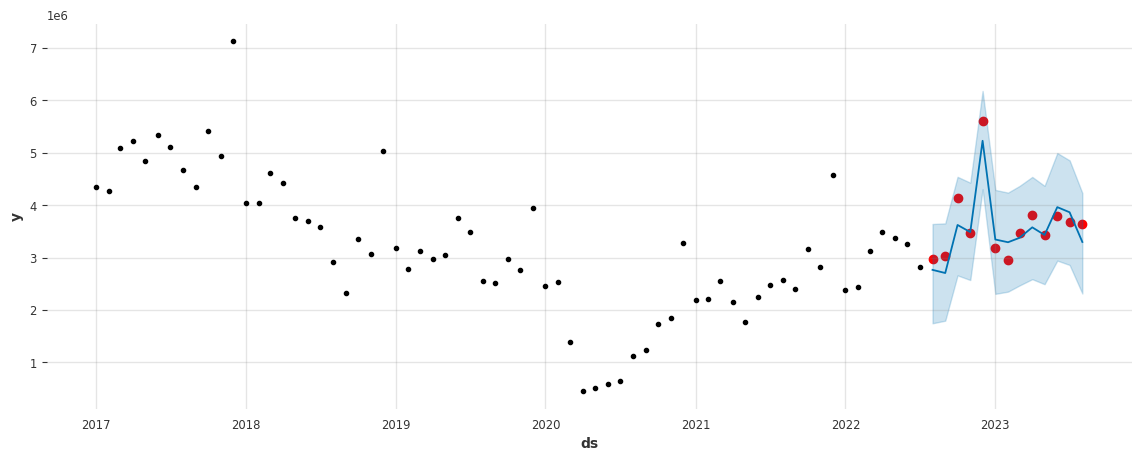

In [47]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

In [48]:
evaluar_metricas(test['y'], X_tst_forecast['yhat'])

MSE:	72051297412
MAE:	229035
RMSE:	268424
MAPE:	nan


In [49]:
from pandas import DataFrame
from pandas import concat
import random
from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from pandas import DataFrame
from pandas import concat
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from neuralprophet import NeuralProphet, set_log_level

In [50]:
m = NeuralProphet()
metrics = m.fit(train[['ds', 'y']], freq="MS")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.529]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 702
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (3) is too small than the required number                     for the learning rate finder (205). The results might not be optimal.


Finding best initial lr:   0%|          | 0/205 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [51]:
future = m.make_future_dataframe(train[['ds', 'y']],n_historic_predictions=True ,periods=13)
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.529]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.765]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.765]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 13 rows at the end with NaNs in 'y' column.


Predicting: 3it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [52]:
m.plot(forecast)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': 'fafc2dd5-c6d8-4525-98fb-bb19ed65993c',
              'x': array([datetime.datetime(2016, 12, 1, 0, 0),
                          datetime.datetime(2017, 1, 1, 0, 0),
                          datetime.datetime(2017, 2, 1, 0, 0),
                          datetime.datetime(2017, 3, 1, 0, 0),
                          datetime.datetime(2017, 4, 1, 0, 0),
                          datetime.datetime(2017, 5, 1, 0, 0),
                          datetime.datetime(2017, 6, 1, 0, 0),
                          datetime.datetime(2017, 7, 1, 0, 0),
                          datetime.datetime(2017, 8, 1, 0, 0),
                          datetime.datetime(2017, 9, 1, 0, 0),
                          datetime.datetime(2017, 10, 1, 0, 0),
                       